In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy
import sklearn.datasets
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 1
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# dgm_utils
from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data
from seminar7_utils import draw_distrib, plot_training_curves

OUTPUT_SEED = 0xBADBEEF

torch.manual_seed(OUTPUT_SEED)
np.random.seed(OUTPUT_SEED)

# <center>Deep Generative Models</center>
## <center>Seminar 7. Part 2</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>06.12.2022</center>


## Plan

1. VAE with Learnable Prior. 
    
    - GMM prior


## VAE with Learnable Prior

<img src="pics/vae-gaussian.png" width=800 height=800 />

Let $\boldsymbol{x} = x_1, \dots, x_N$ are samples from the unknown original data distribution $\pi(x)$; $\boldsymbol{z} = z_1, \dots z_N$ are latent variables.

**Original VAE ELBO objectives**:

$$L(q, \theta) = \mathbb{E}_{\boldsymbol{z} \sim q(\boldsymbol{z}| \boldsymbol{x}, \phi)} \ln p(\boldsymbol{x}|\boldsymbol{z}, \theta) - KL(q( \boldsymbol{z} | \boldsymbol{x}, \phi)||p(\boldsymbol{z}))$$

$$L(\phi, \theta) = \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - KL(q(z| x_n, \phi)||p(z))\right)$$

$$L_{\text{scaled}}(\phi, \theta) = \frac{1}{N} \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - KL(q(z| x_n, \phi)||p(z))\right)$$

**Consider learnable prior $p_{\lambda}(\boldsymbol{z})$**:

$$L_{\text{scaled}}(\phi, \theta, \lambda) = \frac{1}{N} \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - KL(q(z| x_n, \phi)||p_{\lambda}(z))\right) = \\ = \frac{1}{N} \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) + \mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \left[ \log p_{\lambda}(z_n) - \log(q(z_n| x_n, \phi))\right]\right) = \\ = \frac{1}{N} \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \big{[} \ln p(x_n|z_n, \theta) + \log p_{\lambda}(z_n)\big{]} + H\big{[}q(z| x_n, \phi)\big{]}\right)$$

**Question**

Can we model $p_{\lambda}(z)$ as Planar flow?

**Answer**

**No**, the flow $z_{\text{latent}} = f_{\lambda}(z)$ should be practically invertible (i.e. we should be able to recover $g = f^{-1}$) as we need both:

* density estimation (in ELBO objective)

* sampling from $p_{\lambda}(\cdot)$ (VAE sampling procedure)

**Question** 

How can parametrization of prior distribution help us?

### ELBO surgery

Let introduce $q_{\text{agg}}(z)$ with pdf defined as follows: 

$$q_{\text{agg}}(z) = \frac{1}{N} \sum\limits_{n = 1}^{N} q(z | x_n) \, , \, z \in \mathbb{R}^{d_{\text{latent}}}$$

**Theorem**

$$\frac{1}{N} \sum\limits_{n = 1}^{N} KL(q(z| x_n, \phi)||p_{\lambda}(z)) = KL(q_{\text{agg}}(z) || p_{\lambda}(z)) + \frac{1}{N} \sum\limits_{n = 1}^{N} KL(q(z| x_n, \phi)||q_{\text{agg}}(z))$$

<center><img src="pics/leanable_and_not_learnable_priors.png" width=800 /></center>

**Question** 

How can parametrization of prior distribution help us?

**Answer**:

1. Given fixed $\phi_0$, $\theta_0$ : $L_{\text{scaled}}(\phi_0, \theta_0) \leq L_{\text{scaled}}(\phi_0, \theta_0, \lambda^*)$

2. Learnable prior removes **holes** arizing from discrepancy between $q_{\text{agg}}$ and $p(z)$ ($\Rightarrow$ imporoves sampling)

### Practical implementation

Recall the `VAE2d` from the homework 2:

```python
class VAE2d(nn.Module):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent

        # ====
        # your code
        # define encoder and decoder networks
        # the encoder takes n_in elements, has enc_hidden_sizes neurons in hidden layers 
        # and outputs 2 * n_latent (n_latent for means, and n_latent for std)
        # the decoder takes n_latent elements, has dec_hidden_sizes neurons in hidden layers 
        # and outputs 2 * n_in (n_in for means, and n_in for std)
        
        # ====
```
```python

    def prior(self, n):
        # ====
        # your code
        # return n samples from prior distribution (we use standard normal for prior)
        
        # ====
```
```python
    def forward(self, x):
        # ====
        # your code
        # now you have to return from the model 
        # - mu_z - means for variational distribution 
        # - mu_x - means for generative distribution
        # - log_std_z - logarithm of std for variational distribution
        # - log_std_x - logarithm of std for generative distribution
        # we use logarithm, since the std is always positive
        # to get std we will exponentiate it to get rid of this constraint

        # 1) mu_z, log_std_z are outputs from the encoder
        # 2) apply reparametrization trick to get z (input of decoder)
        # (do not forget to use self.prior())
        # 3) mu_x, log_std_x are outputs from the decoder
        #    Note: [mu, log_std = decoder(input).chunk(2, dim=1)]
        
        # ====
        return mu_z, log_std_z, mu_x, log_std_x
```
```python
    def loss(self, x):
        mu_z, log_std_z, mu_x, log_std_x = self(x)
        # ====
        # your code
        # 1) apply model to get mu_z, log_std_z, mu_x, log_std_x
        # 2) compute reconstruction loss using get_normal_nll (it is the first term in ELBO)
        # 3) compute KL loss using get_normal_KL (it is the second term in ELBO)
        
        # ====

        return {
            'elbo_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }
```
```python
    def sample(self, n, sample_from_decoder=True):
        with torch.no_grad():
            # ====
            # your code
            # to sample from VAE model you have to sample from prior
            # and then apply decoder to prior samples.
            # parameter noise indicates whether to sample from decoder
            # or just use means of generative distribution as samples
            # 1) generate prior samples
            # 2) apply decoder
            # 3) sample from the decoder distribution if sample_from_decoder=True
            
            # ====
        return z.cpu().numpy()
```

Recall the standard **VAE loss**:

$$\text{vae_loss} = \frac{1}{\text{batch_size}} \sum\limits_{i = 1}^{\text{batch_size}} \Big{(} - \ln p\big{(} x_{b[i]} \big{|} \mu_z(x_{b[i]} | \phi) + \boldsymbol{\sigma}_z(x_{b[i]} | \phi) \odot \epsilon_i, \theta\big{)} + KL(q(z_{b[i]}| x_{b[i]}, \phi)||p(z_{b[i]}))\Big{)} \approx - \frac{1}{N} L(\phi, \theta)$$
   
**ELBO** objective with learnable prior:

$$L_{\text{scaled}}(\phi, \theta, \lambda) = \frac{1}{N} \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \big{[} \ln p(x_n|z_n, \theta) + \log p_{\lambda}(z_n)\big{]} + H\big{[}q(z| x_n, \phi)\big{]}\right)$$

**Mutual information**: 

$$\mathbb{I}_q(\boldsymbol{x}, \boldsymbol{z}) = \frac{1}{N} \sum\limits_{n = 1}^{N} KL(q(z| x_n, \phi)||q_{\text{agg}}(z))$$

In [3]:
from vae import VAE2d, get_normal_nll

def get_normal_Entropy(log_std):
    '''
    log_std: tensor (bs, D)
    '''
    return log_std + 0.5*(1. + torch.log(2 * torch.tensor(np.pi)))

def mutual_information_est(z, mu_z, log_std_z):
    mix = TD.Categorical(torch.ones(z.size(0)).to(z))
    mv_normals = TD.Normal(mu_z, log_std_z.exp())
    q_aggr = TD.MixtureSameFamily(mix, TD.Independent(mv_normals, 1))
    q_aggr_log_probs = q_aggr.log_prob(z) # (bs,)
    assert len(q_aggr_log_probs.shape) == 1
    q_z_x_log_probs = mv_normals.log_prob(z).sum(-1)
    assert len(q_z_x_log_probs.shape) == 1
    return (q_z_x_log_probs - q_aggr_log_probs).mean()

class VAE2dLearnablePrior(VAE2d):
    
    # HERE WE REDEFINE `prior` from the parent class
    @property
    def prior(self):
        return self._prior

    def __init__(self, prior, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        super().__init__(n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes)
        assert isinstance(prior, nn.Module)
        self._prior = prior

    def forward(self, x):
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        # z = self.prior(mu_z.shape[0]) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)
        # return mu_z, log_std_z, mu_x, log_std_x
        return z, mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x):
        z, mu_z, log_std_z, mu_x, log_std_x = self(x)
        recon_loss = get_normal_nll(x, mu_x, log_std_x).sum(1).mean()
        entropy_loss = get_normal_Entropy(log_std_z).sum(1).mean()
        prior_log_prob_loss = self.prior.log_prob(z).mean()
        mi = mutual_information_est(z, mu_z, log_std_z)

        return {
            'elbo_loss': recon_loss - prior_log_prob_loss - entropy_loss,
            'recon_loss': recon_loss,
            'prior_log_prob_loss': - prior_log_prob_loss,
            'entropy_loss': entropy_loss,
            'kl': - prior_log_prob_loss - entropy_loss,
            'mi': mi,
            'kl_minus_mi': - prior_log_prob_loss - entropy_loss - mi
        }

    def sample(self, n, sample_from_decoder=True):
        with torch.no_grad():
            z = self.prior.sample((n,))
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if sample_from_decoder:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()

#### GMM prior

Используем обучаемую модель `GMM` из четвёртого семинара

In [4]:
from gmm import GMM

class RandomlyInitGMM(GMM):

    @staticmethod
    def make_spd_matrix(K, dim, eps=1e-2):
        As = torch.randn(K, dim, dim)
        return As @ As.transpose(1, 2) + eps * torch.eye(dim).unsqueeze(0).repeat_interleave(K, dim=0)

    def __init__(self, K, dim, mu_multiplier=1.):
        mu = torch.randn(K, dim)*mu_multiplier
        # sigma = self.make_spd_matrix(K, dim)
        sigma = torch.stack([
            torch.tensor(sklearn.datasets.make_spd_matrix(dim)).float()
            for _ in range(K)])
        pi = torch.ones(K)/float(K)
        super().__init__(K, dim, mu, sigma, pi)

    def sample_from_component(self, n_component, shape):
        assert n_component >= 0
        assert n_component < self.K
        with torch.no_grad():
            mu = self.mu[n_component]
            sigma = self.sigma[n_component]
            distrib = TD.MultivariateNormal(mu, sigma)
            sample = distrib.sample(shape)
        return sample

def conditional_sample(model, n_per_component, return_z_samples=True):
    z_samples = []
    x_samples = []
    labels = []
    for i, k in enumerate(range(N_COMPONENTS)):
        with torch.no_grad():
            z = model.prior.sample_from_component(
                k, (n_per_component,))
            mu, log_std = model.decoder(z).chunk(2, dim=1)
            x = torch.randn_like(mu) * log_std.exp() + mu
        z_samples.append(z.detach().cpu().numpy())
        x_samples.append(x.detach().cpu().numpy())
        labels.append(np.zeros(z.size(0)) + i)
    x = np.concatenate(x_samples)
    z = np.concatenate(z_samples)
    l = np.concatenate(labels)
    if return_z_samples:
        return x, l, z
    return x, l

### VAE with learnable priors

#### Moons dataset

In [5]:
def generate_moons_data(count):
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype('float32')
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

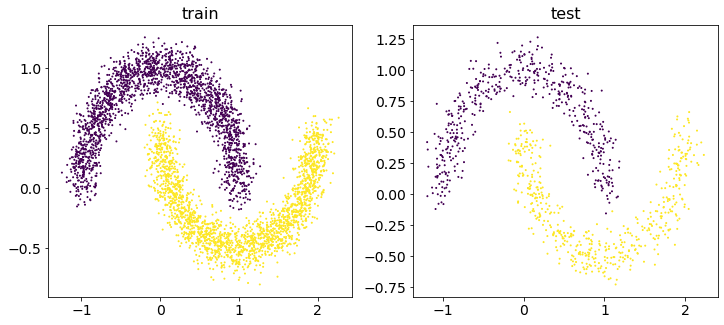

In [6]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Обучаем `VAE` с `GMM` prior-ом

In [7]:
N_COMPONENTS = 3
ENC_HIDDEN_SIZES = [128, 128]
DEC_HIDDEN_SIZES = [128, 128]
BATCH_SIZE = 1024
EPOCHS = 2000
LR = 1e-3
USE_CUDA=True

COUNT = 10000

Initialize gmm model

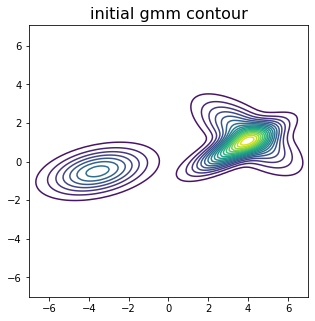

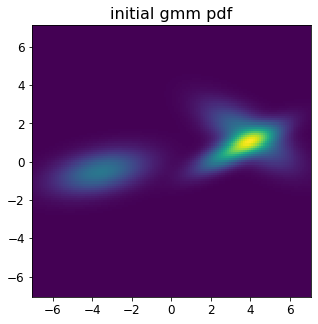

In [8]:
# model
gmm = RandomlyInitGMM(N_COMPONENTS, 2, mu_multiplier=2.)

draw_distrib(gmm, 'initial gmm', x_lim=(-7, 7.), y_lim=(-7, 7.), dx=0.1, dy=0.11)

In [9]:
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = VAE2dLearnablePrior(gmm, 2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).to(DEVICE)

train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss', use_cuda=USE_CUDA, use_tqdm=True
)

  0%|          | 0/2000 [00:00<?, ?it/s]

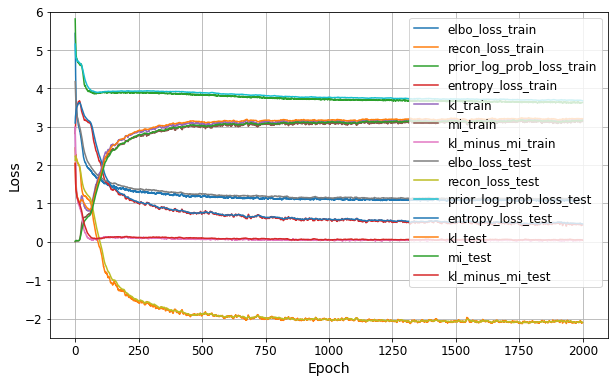

In [11]:
plot_training_curves(train_losses, test_losses, figsize=(10, 6), y_lim=(-2.5, 6), ewma_span=20)

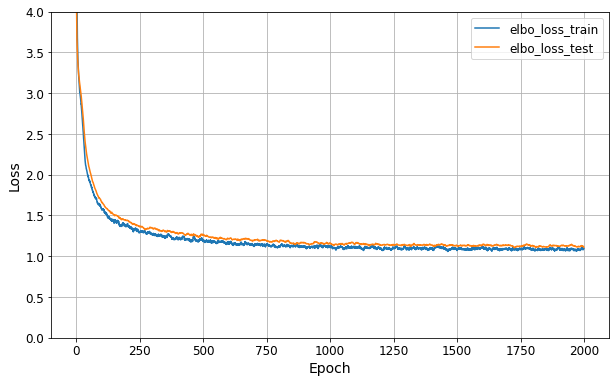

In [15]:
plot_training_curves(train_losses, test_losses, figsize=(10, 6), y_lim=(0, 4), ewma_span=20, keys=['elbo_loss'])

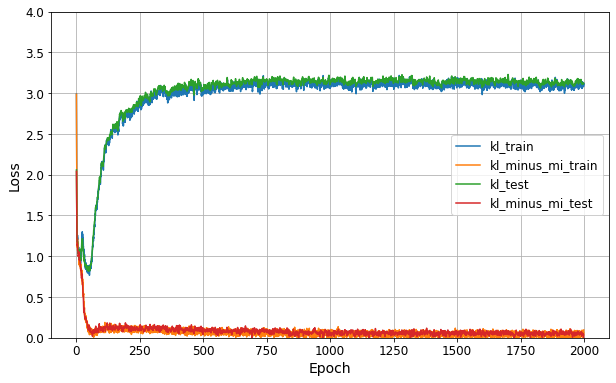

In [16]:
plot_training_curves(train_losses, test_losses, figsize=(10, 6), y_lim=(0, 4), ewma_span=2, keys=['kl', 'kl_minus_mi'])

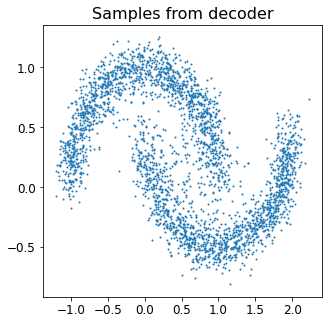

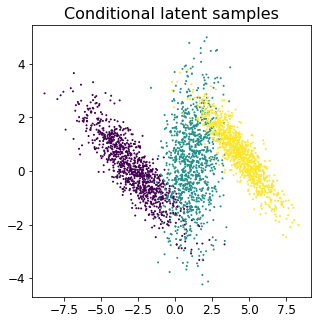

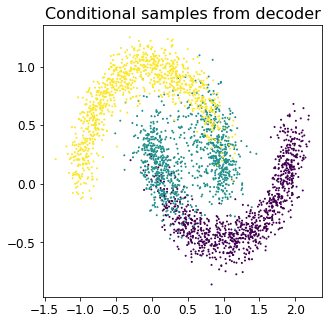

In [17]:
samples = model.sample(3000, sample_from_decoder=True)

# plot_training_curves(train_losses, test_losses)
visualize_2d_samples(samples, title='Samples from decoder')

x, l, z = conditional_sample(model, 1000)
visualize_2d_samples(z, 'Conditional latent samples', l)
visualize_2d_samples(x, 'Conditional samples from decoder', l)

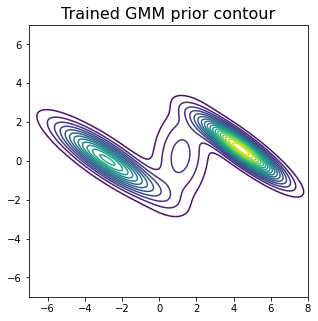

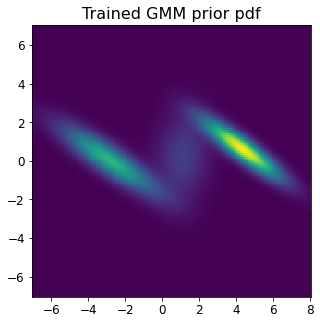

In [18]:
draw_distrib(model.prior, 'Trained GMM prior', x_lim=(-7, 8.), y_lim=(-7, 7), dx=0.1, dy=0.1, device=DEVICE)

**VAE latent distribution**

* Contourplot corresponds to learnable prior $p_{\lambda}(z)$ (GMM)

* Black dots correspond to samples from the $q_{\text{agg}}$ (each black dot $z_n$ is actually sampled from $q(z | x_n, \phi)$)

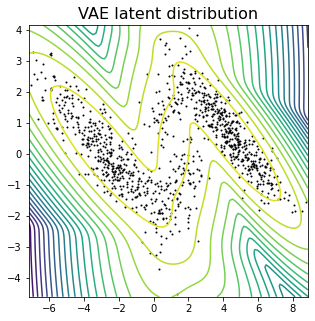

In [19]:
from seminar7_utils import visualize_VAE2d_latent_space

visualize_VAE2d_latent_space(model, test_data, 'VAE latent distribution', device=DEVICE)

#### Digits dataset

In [477]:
def generate_digits_data(normalize=True):
    digits = load_digits()
    # print(digits)
    data, labels = digits['data'], digits['target']
    data = data.astype('float32')
    if normalize:
        data = data/16.
        data = (data - 0.5)/0.5
    count = len(data)
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

In [478]:
train_data, train_labels, test_data, test_labels = generate_digits_data()

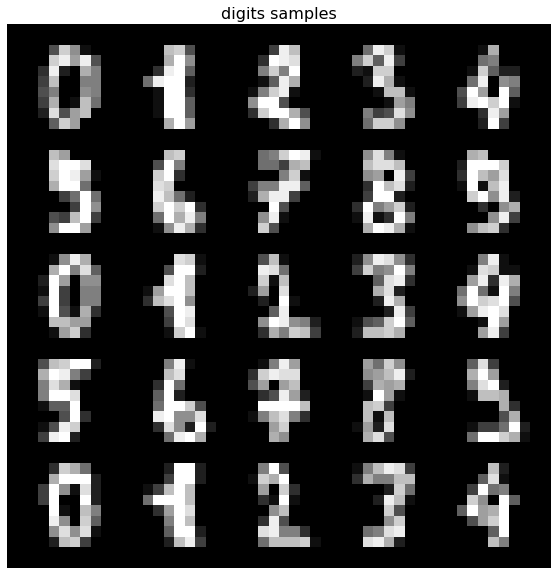

In [479]:
show_samples(undo_scale_data(train_data[:25]).reshape(-1, 1, 8, 8), 'digits samples', figsize=(10, 10))

In [480]:
N_COMPONENTS = 1
ENC_HIDDEN_SIZES = [128,]
DEC_HIDDEN_SIZES = [128,]
BATCH_SIZE = 1024
EPOCHS = 3000
LR = 1e-3
USE_CUDA=True

COUNT = 10000

In [481]:
OUTPUT_SEED = 0xBADBEEF

torch.manual_seed(OUTPUT_SEED)
np.random.seed(OUTPUT_SEED)

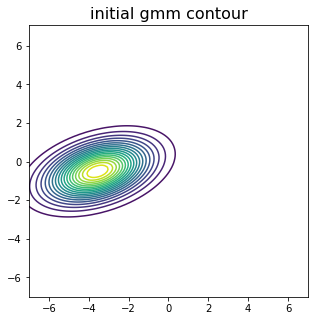

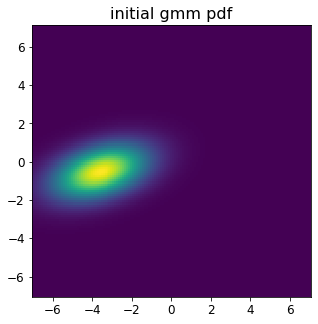

In [482]:
gmm = RandomlyInitGMM(N_COMPONENTS, 2, mu_multiplier=2.)
draw_distrib(gmm, 'initial gmm', x_lim=(-7, 7.), y_lim=(-7, 7.), dx=0.1, dy=0.11)

In [483]:
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = VAE2dLearnablePrior(gmm, 64, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).to(DEVICE)

train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss', use_cuda=USE_CUDA, use_tqdm=True
)

  0%|          | 0/3000 [00:00<?, ?it/s]

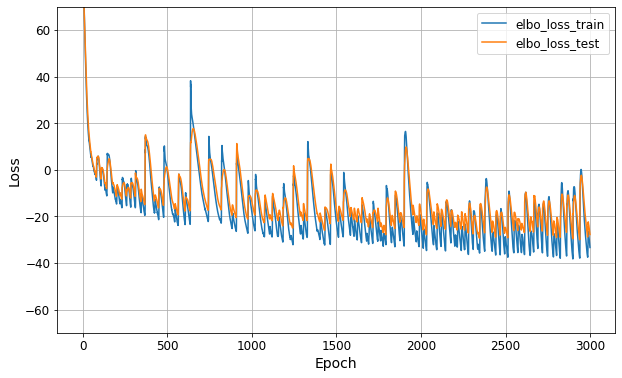

In [484]:
plot_training_curves(train_losses, test_losses, figsize=(10, 6), y_lim=(-70, 70), ewma_span=20, keys=['elbo_loss'])

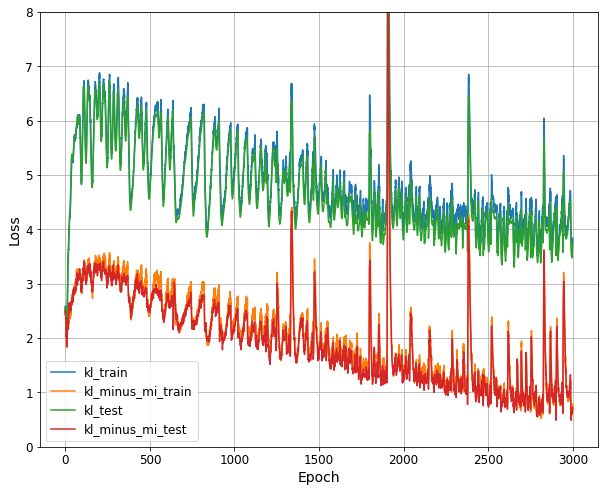

In [485]:
plot_training_curves(
    train_losses, test_losses, figsize=(10, 8), y_lim=(0, 8), ewma_span=None, keys=['kl', 'kl_minus_mi'])

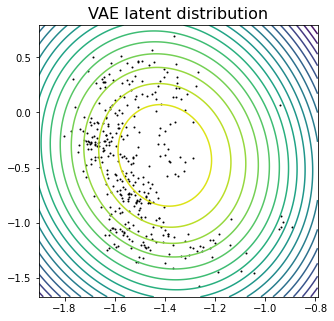

In [486]:
visualize_VAE2d_latent_space(model, test_data, 'VAE latent distribution', device=DEVICE)

In [487]:
N_COMPONENTS = 10
ENC_HIDDEN_SIZES = [128,]
DEC_HIDDEN_SIZES = [128,]
BATCH_SIZE = 1024
EPOCHS = 3000
LR = 1e-3
USE_CUDA=True

COUNT = 10000

In [488]:
OUTPUT_SEED = 0xBADBEEF

torch.manual_seed(OUTPUT_SEED)
np.random.seed(OUTPUT_SEED)

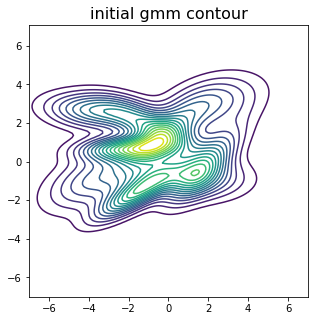

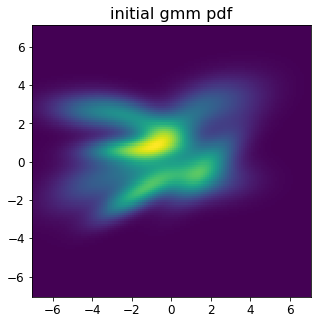

In [489]:
gmm = RandomlyInitGMM(N_COMPONENTS, 2, mu_multiplier=2.)
draw_distrib(gmm, 'initial gmm', x_lim=(-7, 7.), y_lim=(-7, 7.), dx=0.1, dy=0.11)

In [490]:
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = VAE2dLearnablePrior(gmm, 64, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).to(DEVICE)

train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss', use_cuda=USE_CUDA, use_tqdm=True
)

  0%|          | 0/3000 [00:00<?, ?it/s]

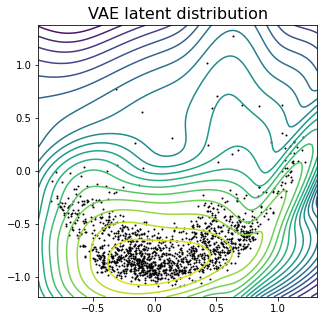

In [491]:
visualize_VAE2d_latent_space(model, train_data, 'VAE latent distribution', device=DEVICE)

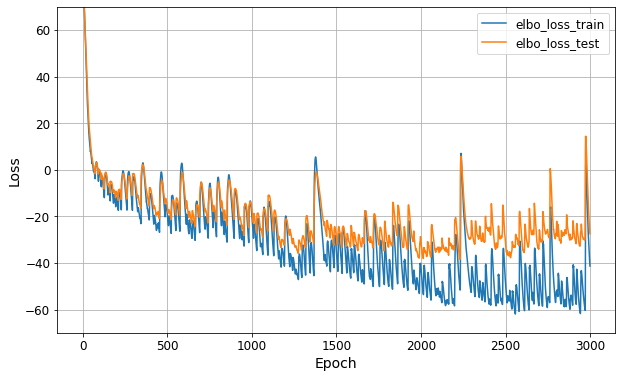

In [492]:
plot_training_curves(
    train_losses, test_losses, figsize=(10, 6), y_lim=(-70, 70), ewma_span=20, keys=['elbo_loss'])

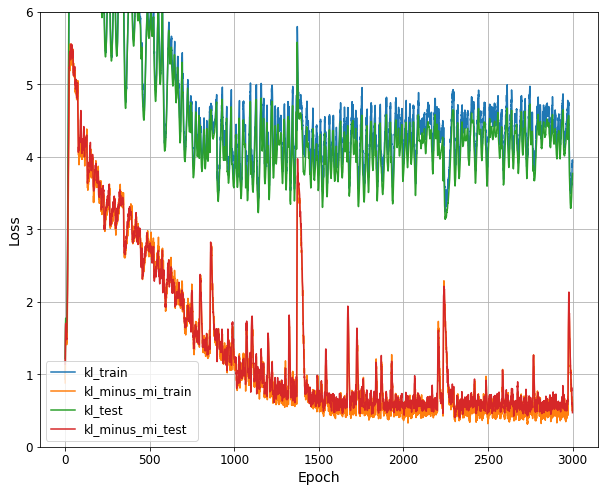

In [493]:
plot_training_curves(
    train_losses, test_losses, figsize=(10, 8), y_lim=(0, 6), ewma_span=None, keys=['kl', 'kl_minus_mi'])

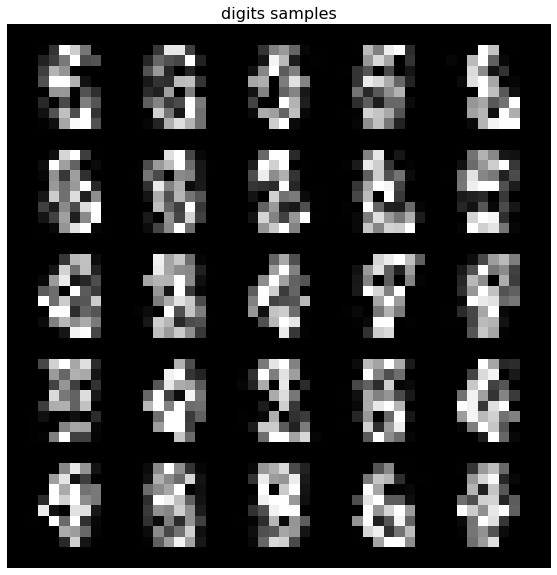

In [497]:
samples = model.sample(25, sample_from_decoder=True).clip(-1., 1.)*0.5 + 0.5
show_samples(samples.reshape(-1, 1, 8, 8), 'digits samples', figsize=(10, 10))

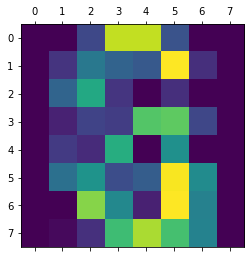

In [500]:
# plt.gray()
plt.matshow(samples[1].reshape(8, 8))
plt.show()

**Question**: 

Can we improve zero `'kl_minus_mi'` in the Digits problem above with fixed VAE `encoder` and `decoder`?

**Answer**:

Yes, just by maximizing $\frac{1}{N} \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \log p_{\lambda}(z_n)\right)$ with respect to $\lambda$

In [501]:
for p in model.encoder.parameters():
    p.requires_grad_(False)

for p in model.decoder.parameters():
    p.requires_grad_(False)

In [502]:
train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=150, lr=LR, loss_key='prior_log_prob_loss', use_cuda=USE_CUDA, use_tqdm=True
)

  0%|          | 0/150 [00:00<?, ?it/s]

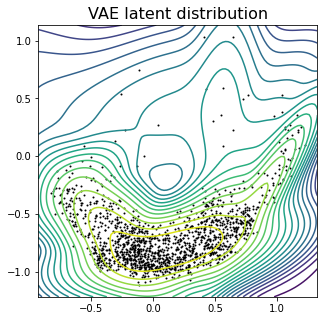

In [503]:
visualize_VAE2d_latent_space(model, train_data, 'VAE latent distribution', device=DEVICE)

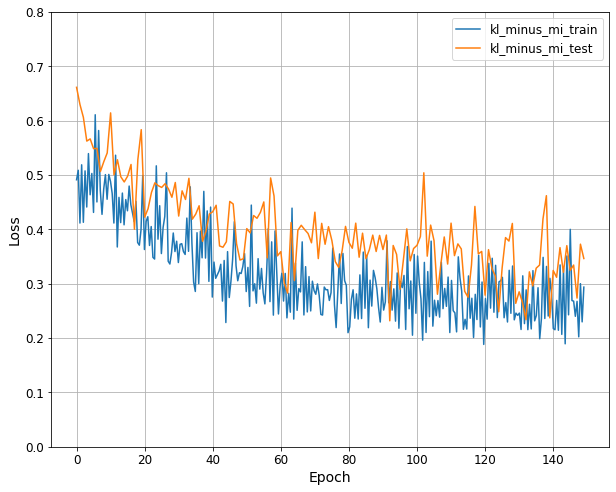

In [504]:
plot_training_curves(
    train_losses, test_losses, figsize=(10, 8), y_lim=(0, 0.8), ewma_span=None, keys=['kl_minus_mi'])